In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv('data/transformed_data.csv')

In [4]:
def get_test_train_split(df):
    # Split features and target
    X = df.drop('Price', axis=1)
    y = df['Price']
    
    # Split into train and test sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [5]:
def get_performance_metrics(y_test, y_pred, print_metrics=True):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Return dictionary of metrics
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

    if print_metrics:
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R2: {r2:.4f}")
    
    return metrics

# Baseline Model

In [6]:
from sklearn.linear_model import LinearRegression


baseline_X_train, baseline_X_test, baseline_y_train, baseline_y_test = get_test_train_split(df)

baseline_model = LinearRegression()
baseline_model.fit(baseline_X_train, baseline_y_train)
y_pred = baseline_model.predict(baseline_X_test)
baseline_metrics = get_performance_metrics(baseline_y_test, y_pred)

MSE: 0.0000
RMSE: 0.0041
MAE: 0.0013
R2: 0.9995


# More models

In [7]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Dictionary to store all models
models = {
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'MLP': MLPRegressor(random_state=42, max_iter=500)
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(baseline_X_train, baseline_y_train)
    y_pred = model.predict(baseline_X_test)
    results[name] = get_performance_metrics(baseline_y_test, y_pred, print_metrics=True)

# Compare R2 scores
r2_scores = {name: metrics['R2'] for name, metrics in results.items()}
r2_scores['Baseline Linear'] = baseline_metrics['R2']


Training Ridge...
MSE: 0.0000
RMSE: 0.0042
MAE: 0.0015
R2: 0.9995

Training Decision Tree...
MSE: 0.0015
RMSE: 0.0394
MAE: 0.0303
R2: 0.9562

Training Random Forest...
MSE: 0.0005
RMSE: 0.0212
MAE: 0.0167
R2: 0.9873

Training Gradient Boosting...
MSE: 0.0002
RMSE: 0.0136
MAE: 0.0107
R2: 0.9948

Training SVR...
MSE: 0.0022
RMSE: 0.0471
MAE: 0.0379
R2: 0.9374

Training KNN...
MSE: 0.0162
RMSE: 0.1275
MAE: 0.1019
R2: 0.5409

Training MLP...
MSE: 0.0005
RMSE: 0.0223
MAE: 0.0175
R2: 0.9859


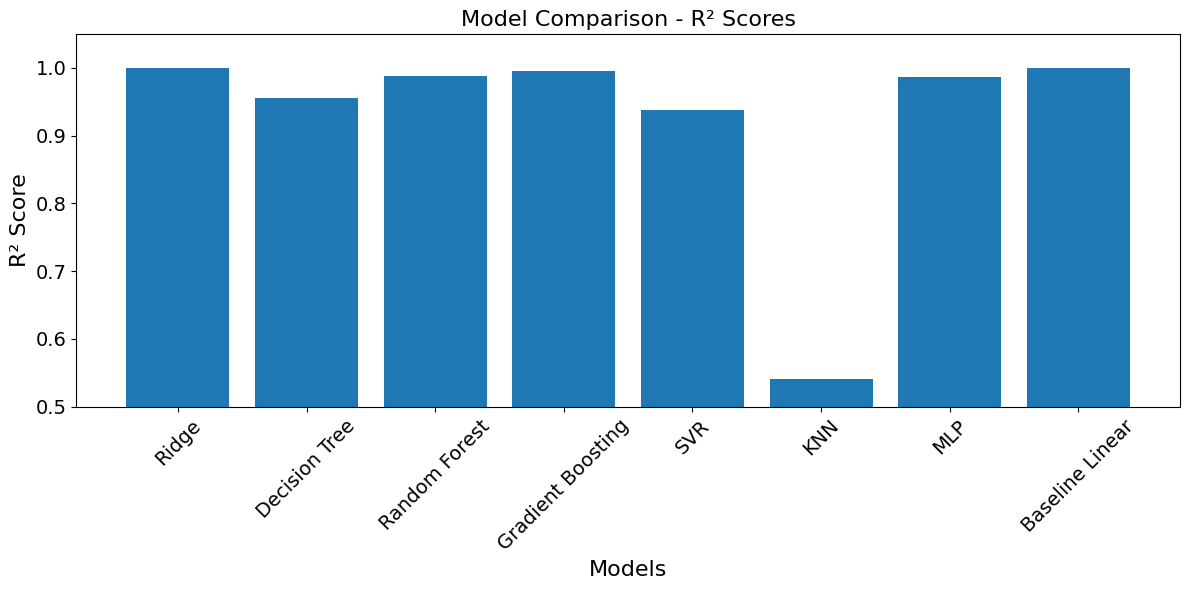

In [8]:
# Plot comparison
plt.figure(figsize=(12, 6))
plt.bar(r2_scores.keys(), r2_scores.values())
plt.ylim(bottom=0.5)  # Set y-axis to start at 0.5
plt.xticks(rotation=45, fontsize=14)  # Increased font size for x-tick labels
plt.title('Model Comparison - R² Scores', fontsize=16)  # Increased font size for title
plt.ylabel('R² Score', fontsize=16)  # Increased font size for y-label
plt.xlabel('Models', fontsize=16)  # Added x-label with larger font
plt.tick_params(axis='y', labelsize=14)  # Increased font size for y-tick labels
plt.tight_layout()
plt.show()

Ridge, Random Forest, Gradient Boosting and MLP look promsing and therefore will be evaluated in more detail.

# Ridge




In [18]:
# Define parameter grid for Ridge
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Initialize GridSearchCV
ridge_grid = GridSearchCV(
    Ridge(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Fit the grid search
print("Performing grid search for Ridge...")
ridge_grid.fit(baseline_X_train, baseline_y_train)

# Print best parameters and score
print("\nBest parameters:", ridge_grid.best_params_)
print("Best R² score:", ridge_grid.best_score_)

# Evaluate best model on test set
best_ridge = ridge_grid.best_estimator_
y_pred = best_ridge.predict(baseline_X_test)
print("\nTest set performance:")
ridge_best_metrics = get_performance_metrics(baseline_y_test, y_pred, print_metrics=True)


Performing grid search for Ridge...

Best parameters: {'alpha': 0.01, 'solver': 'saga'}
Best R² score: 0.9991069555569163

Test set performance:
MSE: 0.0000
RMSE: 0.0041
MAE: 0.0013
R2: 0.9995


# Random Forest

In [8]:
# Define parameter grid for Random Forest
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Initialize GridSearchCV
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Fit the grid search
print("Performing grid search for Random Forest...")
rf_grid.fit(baseline_X_train, baseline_y_train)

# Print best parameters and score
print("\nBest parameters:", rf_grid.best_params_)
print("Best R² score:", rf_grid.best_score_)

# Evaluate best model on test set
best_rf = rf_grid.best_estimator_
y_pred = best_rf.predict(baseline_X_test)
print("\nTest set performance:")
rf_best_metrics = get_performance_metrics(baseline_y_test, y_pred, print_metrics=True)


Performing grid search for Random Forest...

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best R² score: 0.9857926728011417

Test set performance:
MSE: 0.0004
RMSE: 0.0204
MAE: 0.0160
R2: 0.9882


# Gradient Boosting

In [9]:
# Define parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Fit the grid search
print("Performing grid search for Gradient Boosting...")
gb_grid.fit(baseline_X_train, baseline_y_train)

# Print best parameters and score
print("\nBest parameters:", gb_grid.best_params_)
print("Best R² score:", gb_grid.best_score_)

# Evaluate best model on test set
best_gb = gb_grid.best_estimator_
y_pred = best_gb.predict(baseline_X_test)
print("\nTest set performance:")
gb_best_metrics = get_performance_metrics(baseline_y_test, y_pred, print_metrics=True)


Performing grid search for Gradient Boosting...

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best R² score: 0.9972833463285522

Test set performance:
MSE: 0.0001
RMSE: 0.0097
MAE: 0.0075
R2: 0.9973


# MLP

In [10]:
# Define parameter grid for MLP
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [500],  # Increased max_iter to ensure convergence
    'alpha': [0.0001, 0.001, 0.01]  # L2 regularization parameter
}

# Initialize GridSearchCV
mlp_grid = GridSearchCV(
    MLPRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Fit the grid search
print("Performing grid search for MLP...")
mlp_grid.fit(baseline_X_train, baseline_y_train)

# Print best parameters and score
print("\nBest parameters:", mlp_grid.best_params_)
print("Best R² score:", mlp_grid.best_score_)

# Evaluate best model on test set
best_mlp = mlp_grid.best_estimator_
y_pred = best_mlp.predict(baseline_X_test)
print("\nTest set performance:")
mlp_best_metrics = get_performance_metrics(baseline_y_test, y_pred, print_metrics=True)


Performing grid search for MLP...

Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'max_iter': 500}
Best R² score: 0.999455455540574

Test set performance:
MSE: 0.0000
RMSE: 0.0046
MAE: 0.0036
R2: 0.9994


# Cross Validation


In [19]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation for all four models
print("Cross-validation results for Random Forest:")
rf_cv_scores = cross_val_score(best_rf, baseline_X_train, baseline_y_train, cv=5)
print("CV scores:", rf_cv_scores)
print("Mean CV score: {:.4f} (+/- {:.4f})".format(rf_cv_scores.mean(), rf_cv_scores.std() * 2))
print("Training score:", best_rf.score(baseline_X_train, baseline_y_train))
print("\n")

print("Cross-validation results for Gradient Boosting:")
gb_cv_scores = cross_val_score(best_gb, baseline_X_train, baseline_y_train, cv=5)
print("CV scores:", gb_cv_scores)
print("Mean CV score: {:.4f} (+/- {:.4f})".format(gb_cv_scores.mean(), gb_cv_scores.std() * 2))
print("Training score:", best_gb.score(baseline_X_train, baseline_y_train))
print("\n")

print("Cross-validation results for MLP:")
mlp_cv_scores = cross_val_score(best_mlp, baseline_X_train, baseline_y_train, cv=5)
print("CV scores:", mlp_cv_scores)
print("Mean CV score: {:.4f} (+/- {:.4f})".format(mlp_cv_scores.mean(), mlp_cv_scores.std() * 2))
print("Training score:", best_mlp.score(baseline_X_train, baseline_y_train))
print("\n")

print("Cross-validation results for Ridge:")
ridge_cv_scores = cross_val_score(best_ridge, baseline_X_train, baseline_y_train, cv=5)
print("CV scores:", ridge_cv_scores)
print("Mean CV score: {:.4f} (+/- {:.4f})".format(ridge_cv_scores.mean(), ridge_cv_scores.std() * 2))
print("Training score:", best_ridge.score(baseline_X_train, baseline_y_train))

Cross-validation results for Random Forest:
CV scores: [0.98467555 0.98517213 0.9862291  0.98559992 0.98728667]
Mean CV score: 0.9858 (+/- 0.0018)
Training score: 0.9974930705046584


Cross-validation results for Gradient Boosting:
CV scores: [0.99721704 0.99693867 0.99700192 0.99755623 0.99770287]
Mean CV score: 0.9973 (+/- 0.0006)
Training score: 0.9980174138654815


Cross-validation results for MLP:
CV scores: [0.99933165 0.99921126 0.99943893 0.99964695 0.9996485 ]
Mean CV score: 0.9995 (+/- 0.0003)
Training score: 0.9994293090375208


Cross-validation results for Ridge:
CV scores: [0.99923238 0.99870058 0.99875462 0.99924684 0.99960036]
Mean CV score: 0.9991 (+/- 0.0007)
Training score: 0.9991280097347013


This is a good sign, the cross validation scores are high and the training score is also high. This means that the model is not overfitting. But it can show that the training data is really good or artificial.

# Regularization

In [12]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': baseline_X_train.columns,
    'importance': best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10))


Top 10 most important features:
                   feature  importance
4                      Age    0.442151
1                  Mileage    0.311036
0              Engine_Size    0.135592
46      Fuel_Type_Electric    0.048225
49  Transmission_Automatic    0.046127
47        Fuel_Type_Hybrid    0.008802
3              Owner_Count    0.001484
2                    Doors    0.001309
45        Fuel_Type_Diesel    0.001282
48        Fuel_Type_Petrol    0.001279


In [13]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': baseline_X_train.columns,
    'importance': best_gb.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10))


Top 10 most important features:
                   feature  importance
4                      Age    0.441434
1                  Mileage    0.306065
0              Engine_Size    0.132062
49  Transmission_Automatic    0.053099
46      Fuel_Type_Electric    0.051533
47        Fuel_Type_Hybrid    0.014930
48        Fuel_Type_Petrol    0.000483
45        Fuel_Type_Diesel    0.000332
2                    Doors    0.000006
20           Model_C-Class    0.000005


In [14]:
# Feature importance analysis for MLP using absolute values
feature_importance = pd.DataFrame({
    'feature': baseline_X_train.columns,
    'importance': np.abs(best_mlp.coefs_[0]).mean(axis=1)  # Take mean of absolute weights
})
feature_importance = feature_importance.sort_values('importance', ascending=False)  # Changed to descending order

print("\nTop 10 most important features:")
print(feature_importance.head(10))



Top 10 most important features:
                        feature  importance
4                           Age    0.104485
1                       Mileage    0.094412
0                   Engine_Size    0.080074
3                   Owner_Count    0.072656
2                         Doors    0.072338
46           Fuel_Type_Electric    0.055577
51  Transmission_Semi-Automatic    0.055093
49       Transmission_Automatic    0.053477
50          Transmission_Manual    0.053106
48             Fuel_Type_Petrol    0.048867


In [20]:
# Feature importance analysis for Ridge using absolute coefficients
feature_importance = pd.DataFrame({
    'feature': baseline_X_train.columns,
    'importance': np.abs(best_ridge.coef_)  # Take absolute values of coefficients
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10))
          


Top 10 most important features:
                        feature  importance
4                           Age    0.421135
1                       Mileage    0.365770
0                   Engine_Size    0.243468
46           Fuel_Type_Electric    0.076220
49       Transmission_Automatic    0.060981
48             Fuel_Type_Petrol    0.045628
45             Fuel_Type_Diesel    0.045590
51  Transmission_Semi-Automatic    0.030564
50          Transmission_Manual    0.030417
47             Fuel_Type_Hybrid    0.014998


# Is my model overfitting?

## Learning Curves

Generating learning curves...


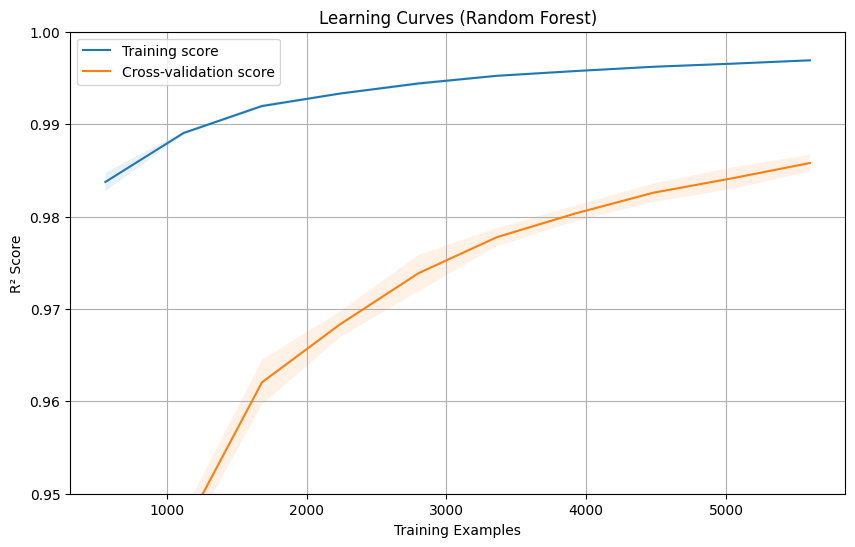

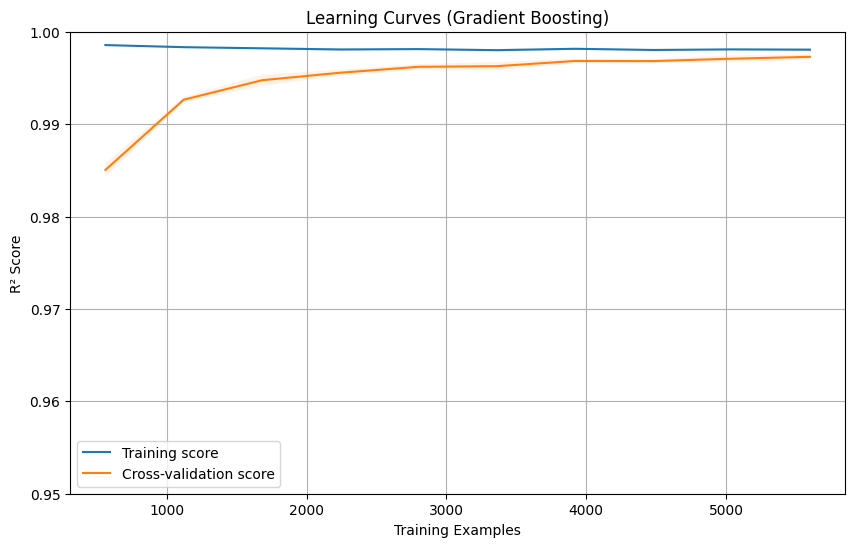

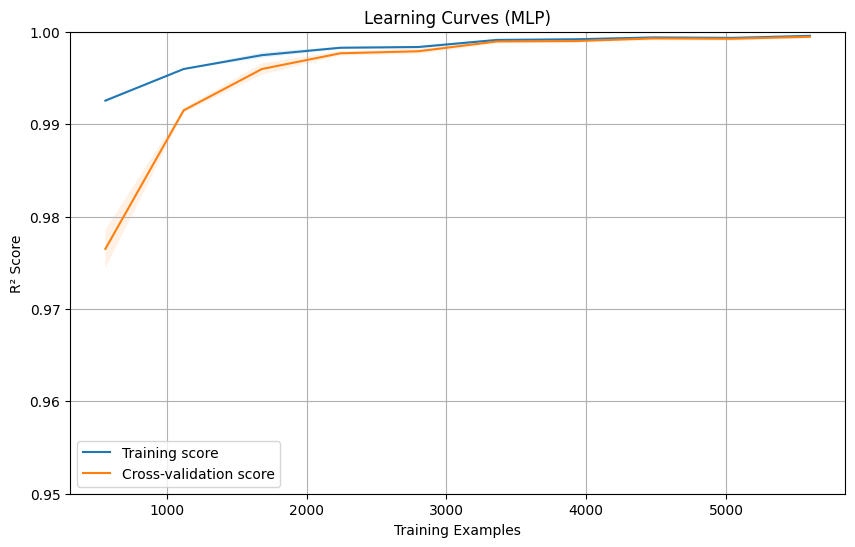

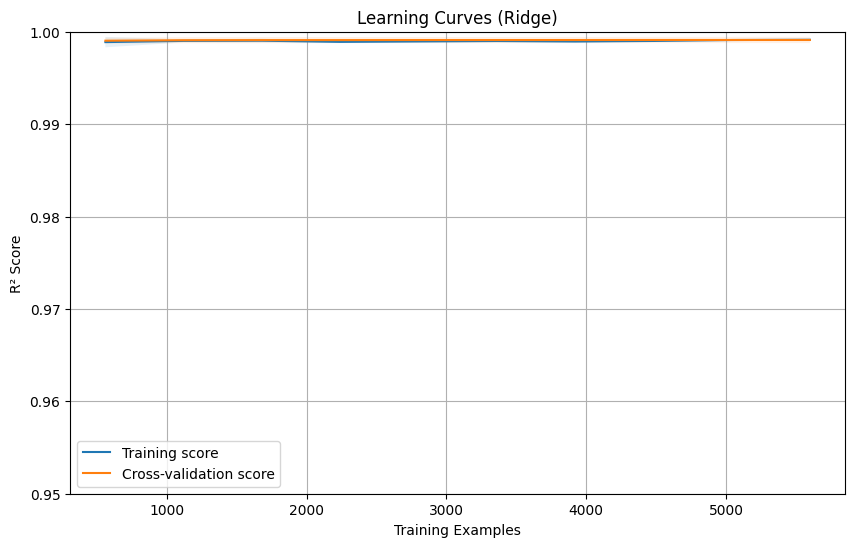

In [23]:
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curves(estimator, X, y, model_name):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='r2'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, val_mean, label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.xlabel('Training Examples')
    plt.ylabel('R² Score')
    plt.title(f'Learning Curves ({model_name})')
    plt.legend(loc='best')
    plt.grid(True)
    plt.ylim(0.95, 1.00)  # Set y-axis limits from 0.95 to 1.00
    plt.show()

# Plot learning curves for each model
print("Generating learning curves...")
plot_learning_curves(best_rf, baseline_X_train, baseline_y_train, "Random Forest")
plot_learning_curves(best_gb, baseline_X_train, baseline_y_train, "Gradient Boosting")
plot_learning_curves(best_mlp, baseline_X_train, baseline_y_train, "MLP")
plot_learning_curves(best_ridge, baseline_X_train, baseline_y_train, "Ridge")

- If the training score is much higher than the validation score, it indicates overfitting
- If both curves are close together and plateau, it suggests good fitting
- If both curves are still rising, you might benefit from more data

## Compare training vs cross-validation

In [22]:
# 2. Compare training vs cross-validation scores
models = {
    'Random Forest': best_rf,
    'Gradient Boosting': best_gb,
    'MLP': best_mlp,
    'Ridge': best_ridge
}

print("\nTraining vs Cross-validation Scores:")
print("-" * 50)
for name, model in models.items():
    train_score = model.score(baseline_X_train, baseline_y_train)
    cv_scores = cross_val_score(model, baseline_X_train, baseline_y_train, cv=5)
    cv_mean = cv_scores.mean()
    score_diff = train_score - cv_mean
    
    print(f"\n{name}:")
    print(f"Training Score: {train_score:.4f}")
    print(f"CV Score (mean): {cv_mean:.4f}")
    print(f"Difference: {score_diff:.4f}")
    
    # Rule of thumb interpretation
    if score_diff > 0.1:
        print("WARNING: Possible overfitting (difference > 0.1)")
    elif score_diff < 0.01:
        print("Good fit (difference < 0.01)")
    else:
        print("Moderate fit (0.01 <= difference <= 0.1)")


Training vs Cross-validation Scores:
--------------------------------------------------

Random Forest:
Training Score: 0.9975
CV Score (mean): 0.9858
Difference: 0.0117
Moderate fit (0.01 <= difference <= 0.1)

Gradient Boosting:
Training Score: 0.9980
CV Score (mean): 0.9973
Difference: 0.0007
Good fit (difference < 0.01)

MLP:
Training Score: 0.9994
CV Score (mean): 0.9995
Difference: -0.0000
Good fit (difference < 0.01)

Ridge:
Training Score: 0.9991
CV Score (mean): 0.9991
Difference: 0.0000
Good fit (difference < 0.01)
